In [8]:
from sklearn.utils import shuffle
import pandas as pd
import datetime
import geopandas as gpd
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
import io
import plotly.express as px

In [ ]:
import ee
ee.Authenticate()
ee.Initialize(project='sentinel-treeclassification')

In [ ]:
df = pd.read_csv('EUForestspecies.csv')

In [ ]:
grouped = df[['X', 'Y', 'SPECIES NAME']].groupby(['X', 'Y'], as_index=False).agg({'SPECIES NAME': ', '.join})
gdf = gpd.GeoDataFrame(
    grouped.drop(labels=['X', 'Y'], axis=1), 
    geometry=gpd.points_from_xy(x=grouped.X, y=grouped.Y, crs='EPSG:3035')
)
gdf.geometry = gdf.buffer(500, cap_style=3).to_crs(epsg=4326)

In [ ]:
class SentinelGetter:
    def mask_s2_clouds(self, image):
      # Quality assessment with resolution in meters
      qa = image.select('QA60')
      # Bits 10 and 11 are clouds and cirrus, respectively.
      cloud_bit_mask = 1 << 10
      cirrus_bit_mask = 1 << 11
      # Both flags should be set to zero, indicating clear conditions.
      mask = (
          qa.bitwiseAnd(cloud_bit_mask)
          .eq(0)
          .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
      )
      return image.updateMask(mask)

    def get_image(self, start_date, end_date):
        selected_bands = [f'B{x}' for x in range(2, 9)] + ['B8A', 'B11', 'B12']
        image = (
            ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
            .filterDate(start_date, end_date)
            .filter(ee.Filter.calendarRange(6, 9, 'month'))
            # Pre-filter to get less cloudy granules.
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
            .map(self.mask_s2_clouds)
            .select(selected_bands)
            .median()
        )
        return image

In [ ]:
sample_ids = shuffle(list(range(gdf.shape[0])), random_state=42)[:1]

start_date = datetime.datetime(2017, 1, 1)
end_date = datetime.datetime(2020, 1, 1)

existing_shards = Path.home().joinpath('sentinel_data').joinpath('shards').joinpath('features_2017')

for sample_id in tqdm(sample_ids):
    
    row = gdf.loc[sample_id]

    params = {'fileFormat': 'NPY'}
    
    sentinel_image = SentinelGetter().get_image(start_date, end_date)
    
    this_bbox = ee.Geometry.BBox(*row.geometry.bounds)
    
    params['expression'] = sentinel_image.clipToBoundsAndScale(
        this_bbox, width=100, height=100)
    
    pixels = ee.data.computePixels(params)
    new_data = np.load(io.BytesIO(pixels))
    new_data = new_data.view((float, len(new_data.dtype.names)))
    new_data[..., :-3] = new_data[..., :-3]/10000
    new_data[..., -3:] = new_data[..., -3:]/255
    
    existing_data = np.load(existing_shards.joinpath(f'feature_{sample_id}.npy'))
    
    print(sample_id, np.isclose(existing_data, new_data).all())

    

In [13]:
existing_shards = Path.home().joinpath('sentinel_data').joinpath('shards').joinpath('features_202003').glob('*')
existing_shards = list(existing_shards)
for shard_path in tqdm(existing_shards):
    existing_data = np.copy(np.load(shard_path))
    existing_data = existing_data[..., :-3]
    np.save(shard_path, existing_data)
    

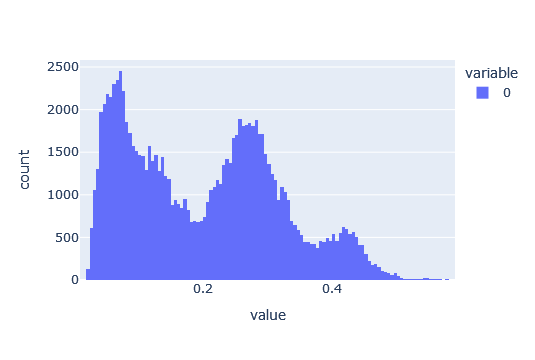

In [14]:
data = np.load(list(existing_shards)[0])

fig1 = px.histogram(data.flatten())
display(fig1)

In [41]:
from multiprocessing.pool import ThreadPool as Pool
from tqdm.notebook import tqdm
import sys
from IPython.display import display
from time import sleep

In [49]:
def test_fun(t):
    a, b = t
    for i in (pbar := tqdm(range(10), leave=False)):
        pbar.set_description(f'Chunk {a}')
        sleep(0.1)

In [50]:
test_inputs = list(zip(range(10), range(10)))

# pool = Pool(processes=2)
# list(tqdm(pool.starmap(test_fun, test_inputs, chunksize=1), total=len(test_inputs)))
# pool.close()
# pool.join()

In [51]:
from concurrent.futures import ThreadPoolExecutor

In [52]:
with ThreadPoolExecutor(max_workers=2) as pool:
    jobs = list(tqdm(pool.map(test_fun, test_inputs), total=len(test_inputs)))


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [29]:
jobs[0]